In [1]:
import os
import numpy as np
import pydicom
import cv2
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import torch.optim as optim

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
def resize_image(image_path):
    dicom = pydicom.dcmread(image_path)

    # Convert the DCM image to a numpy array
    image_array = dicom.pixel_array

    # Resize the image using OpenCV
    resized_image = cv2.resize(image_array, (224, 224))

    return resized_image

In [4]:
# Specify the path to the main directory containing patient folders
main_directory = './small_train_images'

# Dictionary to store image data
image_data = {}

# Iterate over study_id folders
for study_id in os.listdir(main_directory):
    study_id_dir = os.listdir(f'./small_train_images/{study_id}')
    
    # Iterate over series folders for each patient
    for series_id in study_id_dir:
        series_id_dir = os.listdir(f'./small_train_images/{study_id}/{series_id}')
        # Initialize list to store image arrays for the series
        image_arrays = []
        
        # Iterate over DICOM files in the series folder
        for instance in series_id_dir:
            image_path = f'./small_train_images/{study_id}/{series_id}/{instance}'
            resized_image = resize_image(image_path)

            # Append resized_image array to the list
            image_arrays.append(resized_image)
        
        # Vertically stack DCM images
        stacked_images = np.vstack(image_arrays)
        # Store stacked images as a NumPy array
        np_array = np.array(stacked_images)
        print(series_id, np_array.shape)

        # Store image arrays in the dictionary with (study_id, series_id) tuple as key
        image_data[(study_id, series_id)] = np_array

142859125 (8064, 224)
2073726394 (10304, 224)
2399638375 (4256, 224)
3491739931 (4256, 224)
1224932122 (10080, 224)
2231042680 (4032, 224)
3543553307 (4032, 224)
1212326388 (3360, 224)
1638921810 (3360, 224)
3800798510 (6048, 224)
403244853 (6272, 224)
1539051863 (3808, 224)
2500166693 (6048, 224)
2677627096 (3808, 224)
3687121182 (12992, 224)
3753885158 (4032, 224)
434280813 (4032, 224)
1679014482 (10080, 224)
226564374 (3808, 224)
2528347280 (3808, 224)
307069509 (5600, 224)
1152175603 (5152, 224)
1676821058 (5152, 224)
2261718442 (6720, 224)
231278500 (8960, 224)
1379151387 (3360, 224)
1847558962 (4928, 224)
758801267 (3360, 224)
1054713880 (3360, 224)
2448190387 (9632, 224)
702807833 (3360, 224)
3201256954 (12096, 224)
3486248476 (3808, 224)
3666319702 (3808, 224)
132939515 (3808, 224)
1951927562 (5152, 224)
3219733239 (3808, 224)
1570286759 (3360, 224)
2406919186 (4704, 224)
481125819 (3360, 224)


In [5]:
# Check shapes
example_study_id = '4003253'
example_series_id = '702807833'
if (example_study_id, example_series_id) in image_data:
    image = image_data[(example_study_id, example_series_id)]
    print(f"Image shape:", image.shape)
else:
    print("No images found for the specified (study_id, series_id) tuple.")

Image shape: (3360, 224)


In [6]:
# Pad arrays

# Find the maximum shape among all numpy arrays
max_shape = max([np_array.shape for np_array in image_data.values()], key=lambda x: x[0])

for key in image_data:
    np_array = image_data[key]
    padding = max_shape[0] - np_array.shape[0]
    if padding > 0:
        padding_shape = ((0, padding), (0, 0))
        padded_np_array = np.pad(np_array, padding_shape, mode='constant', constant_values=0) # 0 is black (If I'm not mistaken)
        image_data[key] = padded_np_array

# Print the shapes of padded numpy arrays
for key in image_data:
    print(key, image_data[key].shape)

('10728036', '142859125') (12992, 224)
('10728036', '2073726394') (12992, 224)
('10728036', '2399638375') (12992, 224)
('10728036', '3491739931') (12992, 224)
('11340341', '1224932122') (12992, 224)
('11340341', '2231042680') (12992, 224)
('11340341', '3543553307') (12992, 224)
('11943292', '1212326388') (12992, 224)
('11943292', '1638921810') (12992, 224)
('11943292', '3800798510') (12992, 224)
('11943292', '403244853') (12992, 224)
('13317052', '1539051863') (12992, 224)
('13317052', '2500166693') (12992, 224)
('13317052', '2677627096') (12992, 224)
('22191399', '3687121182') (12992, 224)
('22191399', '3753885158') (12992, 224)
('22191399', '434280813') (12992, 224)
('26342422', '1679014482') (12992, 224)
('26342422', '226564374') (12992, 224)
('26342422', '2528347280') (12992, 224)
('26342422', '307069509') (12992, 224)
('29931867', '1152175603') (12992, 224)
('29931867', '1676821058') (12992, 224)
('29931867', '2261718442') (12992, 224)
('29931867', '231278500') (12992, 224)
('3373

In [7]:
# Make 3D arrays

# Group arrays by the first tuple values
grouped_arrays = {}
for key, value in image_data.items():
    if key[0] not in grouped_arrays:
        grouped_arrays[key[0]] = [value]
    else:
        grouped_arrays[key[0]].append(value)

# Stack arrays with the same first tuple values into a 3D array
stacked_arrays = {}
for key, values in grouped_arrays.items():
    stacked_arrays[key] = np.stack(values, axis=0)

stacked_tensors = {}
for key, value in stacked_arrays.items():
    stacked_tensors[key] = torch.from_numpy(value)

# Check the stacked arrays
for key, value in stacked_tensors.items():
    print(f"Stacked arrays for key {key}: {value.shape}")

Stacked arrays for key 10728036: torch.Size([4, 12992, 224])
Stacked arrays for key 11340341: torch.Size([3, 12992, 224])
Stacked arrays for key 11943292: torch.Size([4, 12992, 224])
Stacked arrays for key 13317052: torch.Size([3, 12992, 224])
Stacked arrays for key 22191399: torch.Size([3, 12992, 224])
Stacked arrays for key 26342422: torch.Size([4, 12992, 224])
Stacked arrays for key 29931867: torch.Size([4, 12992, 224])
Stacked arrays for key 33736057: torch.Size([3, 12992, 224])
Stacked arrays for key 4003253: torch.Size([3, 12992, 224])
Stacked arrays for key 4646740: torch.Size([3, 12992, 224])
Stacked arrays for key 7143189: torch.Size([3, 12992, 224])
Stacked arrays for key 8785691: torch.Size([3, 12992, 224])


In [8]:
# Determine the maximum shape
max_shape = tuple(max(arr.shape[i] for arr in stacked_tensors.values()) for i in range(3))

# Pad each tensor to the maximum shape
for key, tensor in stacked_tensors.items():
    pad_shape = [max_shape[i] - tensor.shape[i] for i in range(3)]
    stacked_tensors[key] = F.pad(tensor, (0, pad_shape[2], 0, pad_shape[1], 0, pad_shape[0]))

In [9]:
# Print the new shapes
for key, arr in stacked_tensors.items():
    print(f"Key: {key}, New Shape: {arr.shape}")

Key: 10728036, New Shape: torch.Size([4, 12992, 224])
Key: 11340341, New Shape: torch.Size([4, 12992, 224])
Key: 11943292, New Shape: torch.Size([4, 12992, 224])
Key: 13317052, New Shape: torch.Size([4, 12992, 224])
Key: 22191399, New Shape: torch.Size([4, 12992, 224])
Key: 26342422, New Shape: torch.Size([4, 12992, 224])
Key: 29931867, New Shape: torch.Size([4, 12992, 224])
Key: 33736057, New Shape: torch.Size([4, 12992, 224])
Key: 4003253, New Shape: torch.Size([4, 12992, 224])
Key: 4646740, New Shape: torch.Size([4, 12992, 224])
Key: 7143189, New Shape: torch.Size([4, 12992, 224])
Key: 8785691, New Shape: torch.Size([4, 12992, 224])


In [10]:
# Add targets
targets_df = pd.read_csv('./train.csv')

mapping = {
    'normal/mild': 1,
    'moderate': 2,
    'severe': 3
}
def standardize_and_map(column, mapping):
    return column.str.lower().str.strip().map(mapping)

# List of columns to apply the transformation
columns_to_transform = ['spinal_canal_stenosis_l1_l2',
       'spinal_canal_stenosis_l2_l3', 'spinal_canal_stenosis_l3_l4',
       'spinal_canal_stenosis_l4_l5', 'spinal_canal_stenosis_l5_s1',
       'left_neural_foraminal_narrowing_l1_l2',
       'left_neural_foraminal_narrowing_l2_l3',
       'left_neural_foraminal_narrowing_l3_l4',
       'left_neural_foraminal_narrowing_l4_l5',
       'left_neural_foraminal_narrowing_l5_s1',
       'right_neural_foraminal_narrowing_l1_l2',
       'right_neural_foraminal_narrowing_l2_l3',
       'right_neural_foraminal_narrowing_l3_l4',
       'right_neural_foraminal_narrowing_l4_l5',
       'right_neural_foraminal_narrowing_l5_s1',
       'left_subarticular_stenosis_l1_l2', 'left_subarticular_stenosis_l2_l3',
       'left_subarticular_stenosis_l3_l4', 'left_subarticular_stenosis_l4_l5',
       'left_subarticular_stenosis_l5_s1', 'right_subarticular_stenosis_l1_l2',
       'right_subarticular_stenosis_l2_l3',
       'right_subarticular_stenosis_l3_l4',
       'right_subarticular_stenosis_l4_l5',
       'right_subarticular_stenosis_l5_s1']


In [11]:
# Apply the function to the specified columns
for column in columns_to_transform:
    targets_df[column] = standardize_and_map(targets_df[column], mapping)

In [12]:
test_df = targets_df[targets_df['study_id'] == 4003253]
test_df

,study_id,spinal_canal_stenosis_l1_l2,spinal_canal_stenosis_l2_l3,spinal_canal_stenosis_l3_l4,spinal_canal_stenosis_l4_l5,spinal_canal_stenosis_l5_s1,left_neural_foraminal_narrowing_l1_l2,left_neural_foraminal_narrowing_l2_l3,left_neural_foraminal_narrowing_l3_l4,left_neural_foraminal_narrowing_l4_l5,...,left_subarticular_stenosis_l1_l2,left_subarticular_stenosis_l2_l3,left_subarticular_stenosis_l3_l4,left_subarticular_stenosis_l4_l5,left_subarticular_stenosis_l5_s1,right_subarticular_stenosis_l1_l2,right_subarticular_stenosis_l2_l3,right_subarticular_stenosis_l3_l4,right_subarticular_stenosis_l4_l5,right_subarticular_stenosis_l5_s1
0,4003253,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,...,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0


In [13]:
# Store targets in a dict as torch tensors and rashape them

targets_tensors = {}

for key, arr in stacked_tensors.items():
    target = targets_df[targets_df['study_id'] == int(key)]
    target_study_id = target.iloc[:, :1]
    target_values_int = np.array(target.iloc[:, 1:]).flatten().astype(int) - 1

    # Convert the target array to one-hot encoding with three classes
    num_classes = 3
    one_hot_targets = np.eye(num_classes)[target_values_int]

    # Reshape the one-hot encoded target array to match the desired output shape (25, 3)
    reshaped_targets = one_hot_targets.reshape(-1, num_classes)

    # Convert the numpy array to a torch tensor
    tensor_targets = torch.from_numpy(reshaped_targets)

    targets_tensors[target_study_id.iloc[0, 0]] = tensor_targets

In [14]:
# Print the new shapes
for key, arr in targets_tensors.items():
    print(f"Key: {key}, New Shape: {arr.shape}")
    # if key == 4003253:
    #     print(arr)

Key: 10728036, New Shape: torch.Size([25, 3])
Key: 11340341, New Shape: torch.Size([25, 3])
Key: 11943292, New Shape: torch.Size([25, 3])
Key: 13317052, New Shape: torch.Size([25, 3])
Key: 22191399, New Shape: torch.Size([25, 3])
Key: 26342422, New Shape: torch.Size([25, 3])
Key: 29931867, New Shape: torch.Size([25, 3])
Key: 33736057, New Shape: torch.Size([25, 3])
Key: 4003253, New Shape: torch.Size([25, 3])
Key: 4646740, New Shape: torch.Size([25, 3])
Key: 7143189, New Shape: torch.Size([25, 3])
Key: 8785691, New Shape: torch.Size([25, 3])


In [15]:
for ((key, feature),(key2, targets)) in zip(stacked_tensors.items(), targets_tensors.items()):
    print(f"Key: {key}, New Shape: {feature.shape} | Key: {key2}, New Shape: {targets.shape}")

Key: 10728036, New Shape: torch.Size([4, 12992, 224]) | Key: 10728036, New Shape: torch.Size([25, 3])
Key: 11340341, New Shape: torch.Size([4, 12992, 224]) | Key: 11340341, New Shape: torch.Size([25, 3])
Key: 11943292, New Shape: torch.Size([4, 12992, 224]) | Key: 11943292, New Shape: torch.Size([25, 3])
Key: 13317052, New Shape: torch.Size([4, 12992, 224]) | Key: 13317052, New Shape: torch.Size([25, 3])
Key: 22191399, New Shape: torch.Size([4, 12992, 224]) | Key: 22191399, New Shape: torch.Size([25, 3])
Key: 26342422, New Shape: torch.Size([4, 12992, 224]) | Key: 26342422, New Shape: torch.Size([25, 3])
Key: 29931867, New Shape: torch.Size([4, 12992, 224]) | Key: 29931867, New Shape: torch.Size([25, 3])
Key: 33736057, New Shape: torch.Size([4, 12992, 224]) | Key: 33736057, New Shape: torch.Size([25, 3])
Key: 4003253, New Shape: torch.Size([4, 12992, 224]) | Key: 4003253, New Shape: torch.Size([25, 3])
Key: 4646740, New Shape: torch.Size([4, 12992, 224]) | Key: 4646740, New Shape: torc

In [16]:
# Convert all tensors to float32
feature_tensorstest = [tensor.float() for tensor in stacked_tensors.values()]
target_tensorstest = [tensor.float() for tensor in targets_tensors.values()]

# Stack the tensors
X_train = torch.stack(feature_tensorstest)
y_train = torch.stack(target_tensorstest)

print(X_train.shape, y_train.shape)

torch.Size([12, 4, 12992, 224]) torch.Size([12, 25, 3])


In [17]:
# Make torch DataLoader
batch_size = 2

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

In [18]:
# Check DataLoader batches
for i, train_batch in enumerate(train_loader):
    x_train_batch, y_train_batch = train_batch
    print(f'train tensor {i+1}', '|', x_train_batch.shape, '|', y_train_batch.shape)

train tensor 1 | torch.Size([2, 4, 12992, 224]) | torch.Size([2, 25, 3])
train tensor 2 | torch.Size([2, 4, 12992, 224]) | torch.Size([2, 25, 3])
train tensor 3 | torch.Size([2, 4, 12992, 224]) | torch.Size([2, 25, 3])
train tensor 4 | torch.Size([2, 4, 12992, 224]) | torch.Size([2, 25, 3])
train tensor 5 | torch.Size([2, 4, 12992, 224]) | torch.Size([2, 25, 3])
train tensor 6 | torch.Size([2, 4, 12992, 224]) | torch.Size([2, 25, 3])


In [70]:
num_epochs = 10
learning_rate = 0.01

In [129]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        # self.layer1 = nn.Sequential(
        #     nn.Conv2d(in_channels=4, out_channels=16, kernel_size=5, stride=1, padding=2),
        #     nn.MaxPool2d(kernel_size=(8, 2), stride=(8, 2)))  # Large pooling to reduce height quickly
        # self.layer2 = nn.Sequential(
        #     nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2),
        #     nn.MaxPool2d(kernel_size=(4, 2), stride=(4, 2)))  # Smaller pooling
        
        self.conv1 = nn.Conv2d(in_channels=4, out_channels=16, kernel_size=5, stride=1, padding=2)
        self.pool = nn.MaxPool2d(kernel_size=(8, 2), stride=(8, 2))  # Large pooling to reduce height quickly
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.pool2 = nn.MaxPool2d(kernel_size=(4, 2), stride=(4, 2))  # Smaller pooling

        self.fc1 = nn.Linear(32*406*56, 25*3)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        # x = self.fc1(x)
        # x = x.view(x.size(0), -1)
        x = x.reshape(x.shape[0], -1)
        x = self.fc1(x)
        x = x.reshape(x.shape[0], 25, 3) # added this
        # x = F.softmax(x, dim=1)

        return x

In [130]:
# Apply and check the model
model = CNNModel()
model.to(device)
print(model)

CNNModel(
  (conv1): Conv2d(4, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=(8, 2), stride=(8, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool2): MaxPool2d(kernel_size=(4, 2), stride=(4, 2), padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=727552, out_features=75, bias=True)
)


In [131]:
# Basic check
x = torch.randn(2, 4, 12992, 224)
print(model(x).shape)

torch.Size([2, 25, 3])


In [132]:
# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [133]:
# Training loop
losses = []
for epoch in range(num_epochs):
    for features, targets in train_loader:

        # Move data to GPU
        features, targets = features.to(device), targets.to(device)

        # Ensure the target tensor is a 0D or 1D tensor
        # targets = targets.view(2, -1)

        # Forward pass
        outputs = model(features)
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Append the current loss to the list
    losses.append(loss.item())

    # Print the loss after each epoch
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/10], Loss: 28.8335
Epoch [2/10], Loss: 26.7903
Epoch [3/10], Loss: 26.7774
Epoch [4/10], Loss: 26.7672
Epoch [5/10], Loss: 26.7583
Epoch [6/10], Loss: 26.7512
Epoch [7/10], Loss: 26.7457
Epoch [8/10], Loss: 26.7414
Epoch [9/10], Loss: 26.7379
Epoch [10/10], Loss: 26.7348


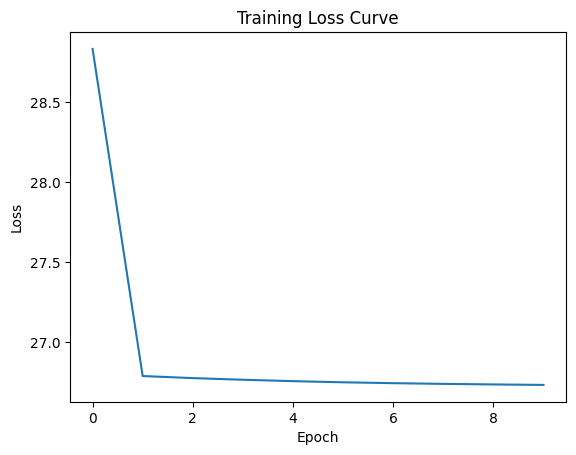

In [135]:
# Plot the loss curve
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.show()

In [158]:
def predict(input_tensor):

    # Convert input tensor to float
    input_tensor = input_tensor.float()

    # Ensure the model is in evaluation mode
    model.eval()
    
    # Disable gradient computation for inference
    with torch.no_grad():
        # Forward pass through the model
        output = model(input_tensor)
        
        # Convert the model output to probabilities using softmax
        probabilities = F.softmax(output, dim=1)
        
        return probabilities

In [160]:
# Try to predict stock prices for Apple company
predict_dirs = os.listdir('./train_images/74294498')

# Dictionary to store image data
test_image_data = {}

for series_id in predict_dirs:
    series_id_dir = os.listdir(f'./train_images/74294498/{series_id}')
    # Initialize list to store image arrays for the series
    image_arrays = []
    
    # Iterate over DICOM files in the series folder
    for instance in series_id_dir:
        image_path = f'./train_images/74294498/{series_id}/{instance}'
        resized_image = resize_image(image_path)

        # Append resized_image array to the list
        image_arrays.append(resized_image)
    
    # Vertically stack DCM images
    stacked_images = np.vstack(image_arrays)
    # Store stacked images as a NumPy array
    np_array = np.array(stacked_images)
    print(series_id, np_array.shape)

    # Store image arrays in the dictionary with (study_id, series_id) tuple as key
    test_image_data[(study_id, series_id)] = np_array

3485741709 (4032, 224)
3742439825 (10976, 224)
507422603 (4032, 224)


In [161]:
# Pad arrays

# Find the maximum shape among all numpy arrays
# max_shape = max([np_array.shape for np_array in test_image_data.values()], key=lambda x: x[0])
max_shape = tuple([12992, 224])

for key in test_image_data:
    np_array = test_image_data[key]
    padding = max_shape[0] - np_array.shape[0]
    if padding > 0:
        padding_shape = ((0, padding), (0, 0))
        padded_np_array = np.pad(np_array, padding_shape, mode='constant', constant_values=0) # 0 is black (If I'm not mistaken)
        test_image_data[key] = padded_np_array

# Print the shapes of padded numpy arrays
for key in test_image_data:
    print(key, test_image_data[key].shape)

('8785691', '3485741709') (12992, 224)
('8785691', '3742439825') (12992, 224)
('8785691', '507422603') (12992, 224)


In [162]:
# Make 3D arrays

# Group arrays by the first tuple values
test_grouped_arrays = {}
for key, value in test_image_data.items():
    if key[0] not in test_grouped_arrays:
        test_grouped_arrays[key[0]] = [value]
    else:
        test_grouped_arrays[key[0]].append(value)

# Stack arrays with the same first tuple values into a 3D array
test_stacked_arrays = {}
for key, values in test_grouped_arrays.items():
    test_stacked_arrays[key] = np.stack(values, axis=0)

test_stacked_tensors = {}
for key, value in test_stacked_arrays.items():
    test_stacked_tensors[key] = torch.from_numpy(value)

# Check the stacked arrays
for key, value in test_stacked_tensors.items():
    print(f"Stacked arrays for key {key}: {value.shape}")

Stacked arrays for key 8785691: torch.Size([3, 12992, 224])


In [163]:
# Determine the maximum shape
# max_shape = tuple(max(arr.shape[i] for arr in test_stacked_tensors.values()) for i in range(3))
max_shape = tuple([4, 12992, 224])

# Pad each tensor to the maximum shape
for key, tensor in test_stacked_tensors.items():
    pad_shape = [max_shape[i] - tensor.shape[i] for i in range(3)]
    test_stacked_tensors[key] = F.pad(tensor, (0, pad_shape[2], 0, pad_shape[1], 0, pad_shape[0]))
max_shape

(4, 12992, 224)

In [164]:
extracted_tensor = test_stacked_tensors['8785691']

# Add a batch dimension
predict_tensor = extracted_tensor.unsqueeze(0)
print(predict_tensor.shape)

torch.Size([1, 4, 12992, 224])


In [165]:
# See the predictions
predictions = predict(predict_tensor)
# predictions = (predictions > 0.5).float()
reshaped_tensor = predictions.view(25, 3)
reshaped_tensor

tensor([[0.0383, 0.0263, 0.0324],
        [0.0402, 0.0385, 0.0323],
        [0.0404, 0.0475, 0.0404],
        [0.0402, 0.0270, 0.0667],
        [0.0468, 0.0269, 0.0324],
        [0.0468, 0.0270, 0.0324],
        [0.0468, 0.0270, 0.0324],
        [0.0384, 0.0270, 0.0324],
        [0.0349, 0.0590, 0.0324],
        [0.0355, 0.0545, 0.0501],
        [0.0468, 0.0270, 0.0324],
        [0.0469, 0.0270, 0.0324],
        [0.0357, 0.0580, 0.0324],
        [0.0331, 0.0542, 0.0323],
        [0.0404, 0.0472, 0.0317],
        [0.0468, 0.0270, 0.0324],
        [0.0468, 0.0284, 0.0324],
        [0.0404, 0.0472, 0.0324],
        [0.0329, 0.0476, 0.0583],
        [0.0368, 0.0528, 0.0324],
        [0.0437, 0.0386, 0.0324],
        [0.0404, 0.0377, 0.0586],
        [0.0344, 0.0473, 0.0586],
        [0.0304, 0.0521, 0.0585],
        [0.0365, 0.0467, 0.0586]])